In [3]:
import csv
import os

import math
import numpy as np
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

from scipy.stats import ttest_rel
from sklearn.decomposition import PCA

In [28]:
# Load Data
data = {}

for (root, dirs, file) in os.walk("../Model_Input/parted_by_participant/"):
    for f in file:
        if ".csv" in f:
            path = root + "/" + f
            df = pd.read_csv(path)
            df.columns.values[0] = 'part'
            df.set_index('part', inplace=True)
            data[f] = df

In [29]:
example = data["BC985436_part_2_concat.csv"]
example

openface_AU01_r_mean  openface_AU02_r_mean  \
part                                                              
neutral_actress                       0.0              0.000024   
neutral_participant                   0.0              0.000110   
joy_actress                           0.0              0.000031   
joy_participant                       0.0              0.000000   
disgust_actress                       0.0              0.000000   
disgust_participant                   0.0              0.000331   

                     openface_AU04_r_mean  openface_AU05_r_mean  \
part                                                              
neutral_actress                  0.000584              0.009011   
neutral_participant              0.006680              0.001599   
joy_actress                      0.004049              0.021636   
joy_participant                  0.104385              0.011049   
disgust_actress                  0.005966              0.002477   
disgust_participant              0.065122              0.014763   

                     openface_AU06_r_mean  openface_AU07_r_mean  \
part                                                              
neutral_actress                  0.155549              0.058929   
neutral_participant              0.120695              0.101853   
joy_actress                      0.146592              0.052890   
joy_participant                  0.145089              0.214220   
disgust_actress                  0.108419              0.098718   
disgust_participant              0.144628              0.154671   

                     openface_AU09_r_mean  openface_AU10_r_mean  \
part                                                              
neutral_actress                  0.021752              0.003736   
neutral_participant              0.097577              0.107562   
joy_actress                      0.029005              0.088695   
joy_participant                  0.159982              0.287083   
disgust_actress                  0.150557              0.269118   
disgust_participant              0.140851              0.245249   

                     openface_AU12_r_mean  openface_AU14_r_mean  ...  \
part                                                             ...   
neutral_actress                  0.012008              0.143134  ...   
neutral_participant              0.060603              0.207225  ...   
joy_actress                      0.032113              0.181128  ...   
joy_participant                  0.059914              0.303908  ...   
disgust_actress                  0.033388              0.246973  ...   
disgust_participant              0.080844              0.280072  ...   

                     libreface_AU04_i_median  libreface_AU05_i_median  \
part                                                                    
neutral_actress                     0.315250                 0.040996   
neutral_participant                 0.283710                 0.041357   
joy_actress                         0.319924                 0.047883   
joy_participant                     0.327916                 0.054320   
disgust_actress                     0.306236                 0.053745   
disgust_participant                 0.328336                 0.049517   

                     libreface_AU06_i_median  libreface_AU09_i_median  \
part                                                                    
neutral_actress                     0.044731                 0.066299   
neutral_participant                 0.041338                 0.067549   
joy_actress                         0.048780                 0.075163   
joy_participant                     0.086922                 0.074942   
disgust_actress                     0.089442                 0.078569   
disgust_participant                 0.074346                 0.078585   

                     libreface_AU012_i_median  libreface_AU015_i_median  \
part                                               

In [31]:
parts = list(example.index)
parts

['neutral_actress',
 'neutral_participant',
 'joy_actress',
 'joy_participant',
 'disgust_actress',
 'disgust_participant']

#### Preperation

In [32]:
# Combine all DataFrames into one
combined_df = pd.concat(data.values())

# Descriptive Statistics
desc_stats = combined_df.describe()
print(desc_stats)

       openface_AU01_r_mean  openface_AU02_r_mean  openface_AU04_r_mean  \
count            990.000000            990.000000            990.000000   
mean               0.129066              0.110908              0.089412   
std                0.119343              0.133629              0.125474   
min                0.000000              0.000000              0.000000   
25%                0.025339              0.002210              0.004165   
50%                0.106938              0.052969              0.034996   
75%                0.203206              0.185848              0.132147   
max                0.511523              0.751264              0.867692   

       openface_AU05_r_mean  openface_AU06_r_mean  openface_AU07_r_mean  \
count            990.000000            990.000000            990.000000   
mean               0.074971              0.096036              0.154058   
std                0.095549              0.101772              0.140153   
min                0.000

In [33]:
# Define method names from column names
methods = ['openface', 'me_graph', 'libreface']

# Define metrics
metrics = ['mean', 'var', 'median']

# (Re-formatting)
# Extract unique AU numbers and convert to useful number (no leading 0, only number-string)
au_numbers = set(col.split('_')[1] for col in combined_df.columns if 'AU' in col)
au_numbers = [''.join(filter(str.isdigit, s)) for s in au_numbers]
au_numbers = [str(int(num)) for num in au_numbers if num]
# sort and remove dublicates
au_numbers = sorted(set(au_numbers))
print(au_numbers)

['1', '10', '12', '14', '15', '17', '2', '20', '23', '24', '25', '26', '28', '4', '45', '5', '6', '7', '9']


#### Functions for nested dictionary for easier sort/filtering

In [50]:
def filter_methods_and_name_in_dict(filtered_list, current_part):
    method_dict = {}
    # filter by method
    for s in filtered_list:
        # get the value and put it in the correct method 
        #val = combined_df[s].values
        val = float(current_part[s])
        if "openface" in s:
            if "_r_" in s:
                method_dict["OpenFace_r"] = val
            if "_c_" in s:
                method_dict["OpenFace_c"] = val
        elif "me_graph" in s:
            method_dict["ME-Graph"] = val
        elif "libreface" in s:
            if "_i_" in s:
                method_dict["LibreFace_i"] = val
            if "_d_" in s:
                method_dict["LibreFace_d"] = val
                    
    return method_dict

method_list = ["OpenFace_r", "OpenFace_c", "LibreFace_i", "LibreFace_d", "ME-Graph"]

In [35]:
def filter_by_metric_in_dict(matched_cols, current_part):
    metric_dict = {}
    for metric in metrics:
        # sort by metrics of respective au
        filtered_list = [s for s in matched_cols if s.endswith(f'_{metric}')]

        # save in dict
        metric_dict[metric] = filter_methods_and_name_in_dict(filtered_list, current_part)
    return metric_dict

In [36]:
def create_nested_dictionary_of_part(current_part):
    au_dict = {}
    
    for au in au_numbers:
        # get every column with the current au
        pattern = re.compile(f'.*_AU0?{au}_.*')
        matched_cols = [col for col in current_part.columns if pattern.match(col)]

        #print(len(matched_cols))
        #print(matched_cols)

        au_dict[au] = filter_by_metric_in_dict(matched_cols, current_part)
    
    return au_dict

In [43]:
def create_nested_dict_by_part(df_participant):
    '''
    Will create a dict like this:
    {part: {au: {metric: {method: value}}}}
    e.g.
    {"neutral_actress": {"4": {"mean": {"OpenFace_c": 0.23}}}}
    '''    
    part_dict = {}
    for part in parts:
        current_part_df = df_participant.loc[[part]] 
        #current_part_df = df_participant.loc[pd.Index([part], name="part")]
        part_dict[part] = create_nested_dictionary_of_part(current_part_df)
        
    return part_dict

In [47]:
def create_nested_dict_of_all_participants():
    nested_dict = {}
    for p_id, participant in data.items():
        nested_dict[p_id] = create_nested_dict_by_part(participant)
    return nested_dict

##### Create Nested dict

In [48]:
nested_dict = create_nested_dict_of_all_participants()

In [49]:
example_dict = create_nested_dict_by_part(example)

In [55]:
# Convert nested dictionary to a DataFrame
df = pd.DataFrame.from_dict({(i, j): example_dict[i][j] 
                             for i in example_dict.keys() 
                             for j in example_dict[i].keys()}, orient='columns')
print(df.columns)
print(df)

MultiIndex([(    'neutral_actress',  '1'),
            (    'neutral_actress', '10'),
            (    'neutral_actress', '12'),
            (    'neutral_actress', '14'),
            (    'neutral_actress', '15'),
            (    'neutral_actress', '17'),
            (    'neutral_actress',  '2'),
            (    'neutral_actress', '20'),
            (    'neutral_actress', '23'),
            (    'neutral_actress', '24'),
            ...
            ('disgust_participant', '24'),
            ('disgust_participant', '25'),
            ('disgust_participant', '26'),
            ('disgust_participant', '28'),
            ('disgust_participant',  '4'),
            ('disgust_participant', '45'),
            ('disgust_participant',  '5'),
            ('disgust_participant',  '6'),
            ('disgust_participant',  '7'),
            ('disgust_participant',  '9')],
           length=114)
                                          neutral_actress  \
                                       

# Plotting

Extracted from Drimalla:
['AU06_c', 'AU12_c','AU15_c', 'AU09_c', 'AU04_c']

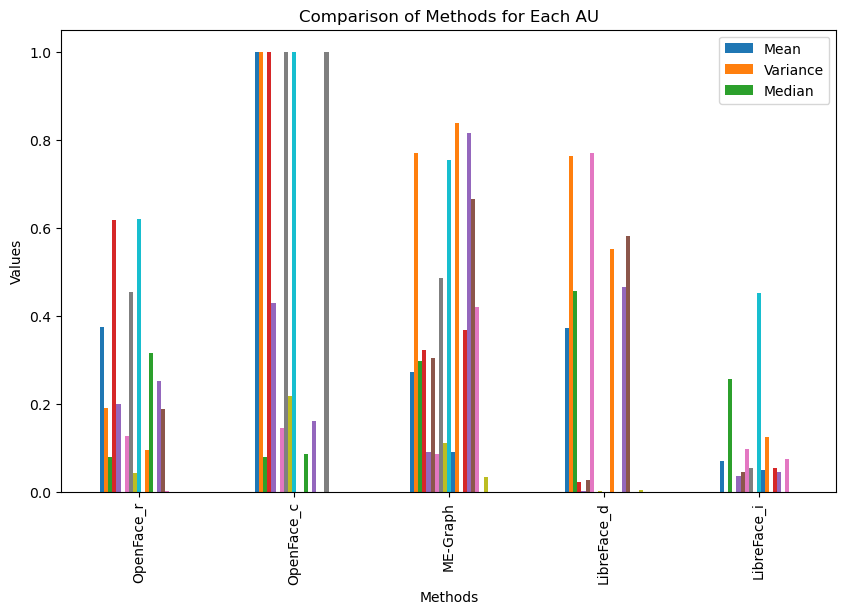

In [12]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for metric in ['mean', 'var', 'median']:
    if metric in df.index.levels[1]:
        df_metric = df.xs(metric, level=1).T
        df_metric.plot(kind='bar', ax=ax, label=metric)

ax.set_title('Comparison of Methods for Each AU')
ax.set_xlabel('Methods')
ax.set_ylabel('Values')
ax.legend(['Mean', 'Variance', 'Median'])
plt.show()


In [57]:
numbers = list(example_dict.keys())
methods = set()
for number in example_dict.values():
    for method in number["mean"].keys():
        methods.add(method)

methods = list(methods)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

bar_width = 0.15

fig, ax = plt.subplots()

for i, method in enumerate(method_list):
    means = []
    variances = []
    medians = []
    for number in numbers:
        means.append(example_dict[number]["mean"].get(method, np.nan))
        variances.append(example_dict[number]["var"].get(method, np.nan))
        medians.append(example_dict[number]["median"].get(method, np.nan))

    ax.errorbar(numbers, means, yerr=variances, fmt='o', label=f'{method} mean', color=colors[i % len(colors)])
    #ax.bar(numbers, means, bar_width, yerr=variances, label=f'{method} mean', color=colors[i % len(colors)])
    ax.plot(numbers, medians, 'x', color=colors[i % len(colors)])

ax.set_xlabel('Number')
ax.set_ylabel('Value')
ax.set_title('Comparison of Methods')
ax.legend()
plt.show()

KeyError: 'mean'

In [ ]:
# Populate the nested dictionary
for col in combined_df.columns:
    if au in col:
        method, au_metric = col.split('_AU')
        for metric in metrics:
            au, metric = au_metric.split(f'_{metric}')
        
        if au not in nested_dict:
            nested_dict[au] = {}
        if metric not in nested_dict[au]:
            nested_dict[au][metric] = {}
        
        nested_dict[au][metric][method] = combined_df[col].tolist()

# Example output
print(nested_dict)

In [ ]:
# Comparative Analysis
au_dict = {}
for au in au_numbers:
    au_dict = {}
    for metric in metrics:
        method_cols = []
        for method in methods:
            pattern = re.compile(f'{method}_AU0?{au}_.*{metric}')
            matched_cols = [col for col in combined_df.columns if pattern.match(col)]
            print(matched_cols)
            if matched_cols:
                method_cols.append(matched_cols[0])
        #method_cols = [f'{method}_AU*{au}*_{metric}' for method in methods]
        
        # Ensure all methods have the column
        if all(col in combined_df.columns for col in method_cols):
            method_dfs = [combined_df[col] for col in method_cols]
            
            # Paired t-test between methods
            for i in range(len(methods)):
                for j in range(i+1, len(methods)):
                    t_stat, p_val = ttest_rel(method_dfs[i], method_dfs[j])
                    print(f'{method_cols[i]} vs {method_cols[j]}: t-statistic = {t_stat}, p-value = {p_val}')
